In [2]:
#add these to top of notebook to reload and to plot inlnie
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [118]:
#import the libraries
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from IPython.display import display

Set the path to the folder where the training data set is downloaded from Kaggle. Size is set to 224 as resnet is optiized for that size. We use resnext101_64 architecture for this training.
batch size is set to 16 and can be altered as per memory requirements

In [4]:
# initialize variables
PATH = '/fastai/data/dogbreed/'
sz = 224
arch = resnext101_64
bs = 16

some code to set and check cuda device number

In [5]:
torch.cuda.set_device(1)

In [6]:
torch.cuda.current_device()

1

List the path and check the files

In [7]:
!ls {PATH}

labels.csv	sample_submission.csv	   test      tmp    train.zip
labels.csv.zip	sample_submission.csv.zip  test.zip  train


For this dataset the file name and labels are in the csv. unlike folder based classification so we load the labels file and use the indexes of labels to split them into training and cross validation (cv) indexes get cross validation indexes would randomly fetch 20% of idxs from the whole list

In [8]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

n

10222

In [9]:
len(val_idxs)

2044

In [10]:
val_idxs

array([2882, 4514, 7717, ..., 8922, 6774,   37])

we read the lavels csv file use pandas which provides a pandas dataframe. then we print some rows to test

In [11]:
label_df = pd.read_csv(label_csv)
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Then we pivot the dataframe to group data by breed and count numbers its a typical groupby function. We sort them descendig to find the most number of samples in this case its scottish_deerhound which has 126 records

In [12]:
label_df.pivot_table(index="breed",aggfunc=len).sort_values('id',ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


create a transformation model to augment the images we zoom by 1.1 and augment by transforming sideOn. This provides more images in different side positions to sample and to learn

In [13]:
tfms = tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)

Build the classifier from CSV this time and pass the training folder name, the list of labels in csv and test folder name, the validation sets. We also pass the suffix since the labels csv does not have the image name in full. We pass the transformations and batch size. The object classifier becomes the data object

In [14]:
data= ImageClassifierData.from_csv(PATH,'train',f'{PATH}labels.csv',
                                   test_name='test',val_idxs=val_idxs,suffix='.jpg',
                                   tfms=tfms,bs=bs)

Now lets access the data and check it. Data object has trn_ds for all training data set and it has property fnames for file names. 

In [17]:
fn = PATH + data.trn_ds.fnames[9];fn

'/fastai/data/dogbreed/train/00792e341f3c6eb33663e415d0715370.jpg'

Open the image and see

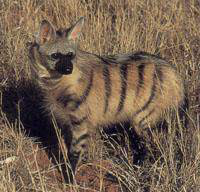

In [18]:
img = PIL.Image.open(fn);img

Then check image sizes, if large then it may not be optimal so if its small. Since Resnet and Imagenet are optimized for 224X224 or 299X299 sizes we need to check that

In [19]:
img.size

(200, 192)

Now we create a data dictionary with key/valye filename/size

In [20]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [21]:
size_d.values()

dict_values([(500, 375), (500, 375), (500, 500), (500, 375), (500, 470), (231, 227), (500, 332), (402, 343), (250, 223), (200, 192), (374, 212), (333, 500), (500, 375), (390, 320), (400, 346), (200, 280), (500, 375), (375, 500), (500, 333), (300, 257), (450, 338), (500, 375), (594, 407), (375, 500), (400, 293), (500, 375), (350, 257), (401, 500), (500, 333), (500, 375), (500, 500), (500, 375), (500, 333), (500, 375), (288, 288), (500, 375), (350, 332), (500, 375), (300, 208), (360, 315), (337, 500), (200, 280), (500, 500), (500, 358), (405, 500), (500, 375), (500, 333), (500, 329), (500, 375), (500, 375), (500, 333), (500, 375), (500, 333), (500, 375), (334, 500), (500, 375), (500, 500), (450, 443), (360, 337), (500, 294), (500, 350), (500, 375), (500, 375), (500, 334), (500, 390), (500, 375), (500, 375), (500, 375), (500, 375), (500, 360), (500, 375), (500, 378), (500, 500), (363, 500), (500, 375), (333, 500), (500, 333), (500, 375), (591, 394), (500, 338), (500, 389), (196, 336), (32

size_d.values holds the sizes which are width/height. Next we unpack the size_d values into rows(width) and columns(height). *size_d.values would unpack a list and zip would zip into tuples and list would convert them to list

In [22]:
row_sz,col_sz = list(zip(*size_d.values()))

In [23]:
col_sz

(375,
 375,
 500,
 375,
 470,
 227,
 332,
 343,
 223,
 192,
 212,
 500,
 375,
 320,
 346,
 280,
 375,
 500,
 333,
 257,
 338,
 375,
 407,
 500,
 293,
 375,
 257,
 500,
 333,
 375,
 500,
 375,
 333,
 375,
 288,
 375,
 332,
 375,
 208,
 315,
 500,
 280,
 500,
 358,
 500,
 375,
 333,
 329,
 375,
 375,
 333,
 375,
 333,
 375,
 500,
 375,
 500,
 443,
 337,
 294,
 350,
 375,
 375,
 334,
 390,
 375,
 375,
 375,
 375,
 360,
 375,
 378,
 500,
 500,
 375,
 500,
 333,
 375,
 394,
 338,
 389,
 336,
 240,
 478,
 306,
 500,
 375,
 375,
 236,
 382,
 500,
 360,
 375,
 375,
 453,
 375,
 375,
 375,
 261,
 490,
 333,
 381,
 375,
 375,
 375,
 330,
 333,
 375,
 375,
 375,
 500,
 320,
 382,
 500,
 398,
 480,
 184,
 500,
 333,
 156,
 500,
 375,
 262,
 500,
 332,
 400,
 333,
 500,
 344,
 299,
 500,
 500,
 160,
 375,
 389,
 500,
 200,
 500,
 554,
 347,
 405,
 180,
 375,
 333,
 300,
 375,
 333,
 338,
 360,
 349,
 436,
 361,
 315,
 232,
 500,
 163,
 333,
 375,
 500,
 374,
 343,
 500,
 500,
 604,
 333,
 400,
 375

Next we use matplot lib, plt usually stands for matplot lib object. Using matplotlib we plot the histogram the distribution of values. We find that most images have width 500 and height. About 5K of them. 

(array([3023., 5024.,   92.,   15.,    5.,    3.,   13.,    2.,    0.,    1.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

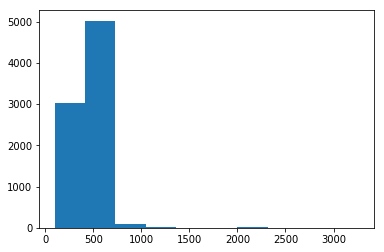

In [24]:
plt.hist(row_sz)

(array([2870., 5121.,  128.,   25.,   10.,   15.,    5.,    2.,    0.,    2.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

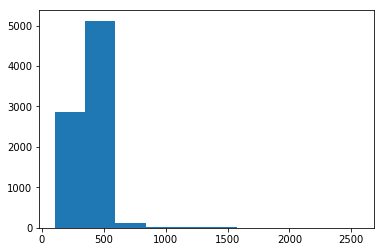

In [25]:
plt.hist(col_sz)

We find that most of them are in range of 500. But there are some with high values like 2500 and 3000. We can reduce the samples by limiting them to 1000. But we need to convert the list to np.array before that

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

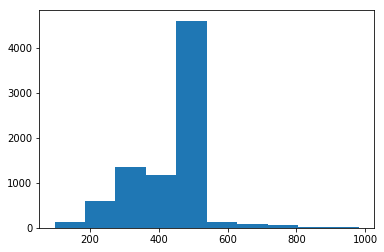

In [26]:
row_sz = np.array(row_sz)
plt.hist(row_sz[row_sz<1000])

check size distribution for columns (heights) too

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

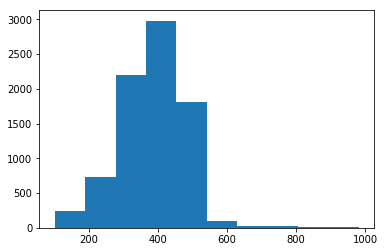

In [27]:
col_sz = np.array(col_sz)
plt.hist(col_sz[col_sz < 1000])

Check some of the training sets and test sets lengths and the number of classes and print some classes

In [28]:
len(data.trn_ds),len(data.test_ds)

(8178, 10357)

In [29]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

Next we start to train. Before training we write a function called get Data to wrap the classifier creation with different sizes and batch sizes this allows for experimenting with smaller sizes first. So smaller images first would run fast. Larger images later would run out of GPU memory. If you see Cuda out of memory error restart notebook kernal only way to fix it.

In [30]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH,'train',f'{PATH}labels.csv',test_name='test',
                                        num_workers=4,val_idxs=val_idxs,suffix='.jpg',tfms=tfms,bs=bs)
    return data if sz>300 else data.resize(340,'tmp')

In [31]:
#get data with some size now
data = get_data(224,bs)
# get a precomputed learning object
learn = ConvLearner.pretrained(arch,data,precompute=True)
# train with learning rate 1 e neg 2 (1e-2 or 0.01) and 5 epochs
learn.fit(1e-2,5)

epoch      trn_loss   val_loss   accuracy                    
    0      0.656051   0.339708   0.882583  
    1      0.418994   0.291741   0.89775                     
    2      0.274506   0.285973   0.910959                    
    3      0.223331   0.278394   0.908023                    
    4      0.175318   0.286194   0.909491                    



[array([0.28619]), 0.9094911937377691]

We tried with precompute = True for this to work some pretrained weights need to be downloaded from http://files.fast.ai/models/weights.tgz to /fastai/fastai/weights folder after the training we get a decent accuracy of 91%. We can then train without precompute. Note: 1 epoch is entire training set and learning rate adjustments in between batches. Cycle is number of epochs per cycle.

In [32]:
# now lets set precompute to False
# and train again
learn.precompute = False
learn.fit(1e-2,5,cycle_len=1)


epoch      trn_loss   val_loss   accuracy                    
    0      0.233959   0.259436   0.915362  
    1      0.251042   0.244983   0.920744                    
    2      0.235615   0.256482   0.917319                    
    3      0.239108   0.246249   0.917319                    
    4      0.216774   0.251881   0.918787                    



[array([0.25188]), 0.9187866927592955]

By setting precompute to false and training again with learning rate 1e-2 for 5 epochs  we got an accuracy of 92%. A little better. Now lets save what we got and reload it.

Now that we have trained with a size of image, we can increase the size of image. This helps to avoide over fitting

In [33]:
learn.set_data(get_data(299,bs))

In [34]:
#now lets train with larger size images
learn.fit(1e-2,3,cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.207791   0.228961   0.931018  
    1      0.256081   0.248795   0.917319                    
    2      0.215546   0.248288   0.921233                    



[array([0.24829]), 0.9212328767123288]

At this point sometimes validation loss may be lower than training loss and this may be due to underfitting. To work around that set cycle_mult to 2 which means each cycle the length/number of epochs double that is 1,2, 4

In [35]:
learn.fit(1e-2,3,cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.218821   0.240738   0.923679  
    1      0.228275   0.247586   0.919276                    
    2      0.165801   0.243194   0.919276                    
    3      0.187709   0.259832   0.917319                    
    4      0.163403   0.262816   0.920744                    
    5      0.191455   0.254036   0.921722                    
    6      0.190404   0.247935   0.924658                    



[array([0.24794]), 0.9246575342465754]

In this case even with Cycle_mult=2 there was not much change in the results. But it may be different some other times. Next we can try TTA ( test time augmentation)

In [36]:
log_preds, y = learn.TTA()

In [55]:
log_preds.shape

(5, 2044, 120)

In [56]:
y.shape

(2044,)

In [63]:
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs,y), metrics.log_loss(y,probs)

(0.9290606653620352, 0.22598668055322862)

In [40]:
#due to some library incompatabilty some of the following code was used
# to reshape data - is commented now
##logPreds = torch.from_numpy(log_preds)
##targs = torch.from_numpy(y)

In [41]:
#logPreds.shape

torch.Size([5, 2044, 120])

In [43]:
#logPreds1 = logPreds[1]
#logPreds1.shape

torch.Size([2044, 120])

In [44]:
#prs =  torch.max(logPreds1,dim=1)[1]

#prs.shape

torch.Size([2044])

In [45]:
#targs.shape

torch.Size([2044])

In [46]:
#trnaccuracy = accuracy(logPreds1,targs)
#trnaccuracy

0.910958904109589

In [47]:
#probs = np.exp(log_preds)

#y.shape , probs.shape

((2044,), (5, 2044, 120))

In [49]:
#probs1 = probs[-1,:,:]
#probs1.shape

(2044, 120)

In [50]:
#trnloss = metrics.log_loss(y,probs1)
#trnloss

0.26723218795890885

In [51]:
#trnaccuracy , trnloss

(0.910958904109589, 0.26723218795890885)

In [60]:
len(data.val_ds.y), data.val_ds.y[:5]

(2044, array([19, 15,  7, 99, 73]))

In [61]:
learn.save('299_pre')
learn.load('299_pre')

In [53]:
learn.fit(1e-2,1,cycle_len=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.160352   0.256702   0.917808  
    1      0.156808   0.256398   0.92319                      



[array([0.2564]), 0.9231898238747553]

In [64]:
learn.save('299_pre')

In [65]:
log_preds, y = learn.TTA()

In [68]:
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs,y), metrics.log_loss(y,probs)

(0.9271037181996086, 0.22209305730633963)

This dataset is similar to Imagenet. So training convolutional layers wont help ,uch. so no need to unfreeze

## Create Submission

In [66]:
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [67]:
data.test_ds.fnames

['test/000621fb3cbb32d8935728e48679680e.jpg',
 'test/00102ee9d8eb90812350685311fe5890.jpg',
 'test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'test/002f80396f1e3db687c5932d7978b196.jpg',
 'test/0036c6bcec6031be9e62a257b1c3c442.jpg',
 'test/0041940322116ae58c38130f5a6f71f9.jpg',
 'test/0042d6bf3e5f3700865886db32689436.jpg',
 'test/004476c96f575879af4af471af65cae8.jpg',
 'test/00485d47de966a9437ad3b33ac193b6f.jpg',
 'test/00496f65de6cc319145ce97bd6e90360.jpg',
 'test/004bf14426d1a830d459a9e0c0721309.jpg',
 'test/004c3721eb88358f462cdcec6b2380b7.jpg',
 'test/00559f56aab7e0a7749220f6aed65162.jpg',
 'test/005b281f1a4d6f29d527c9585e9bd33c.jpg',
 'test/005b6c6c76fefd6b458ef6fb6e54da6e.jpg',
 'test/006870b49353779b25eeb91fed43c31a.jpg',
 'test/0068f3a21b159ece126a28580cd

In [69]:
log_preds, y = learn.TTA(is_test=True)
probs= np.mean(np.exp(log_preds),0)

In [70]:
probs.shape

(10357, 120)

In [71]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [72]:
df.insert(0,'id', [o[5:-4] for o in data.test_ds.fnames])

In [73]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,9.354342e-09,2.328313e-07,4.824278e-08,2.297397e-09,8.639810e-10,1.977654e-08,1.022322e-08,3.546635e-09,7.111995e-09,...,5.227032e-08,2.216841e-08,5.447583e-09,1.616551e-08,1.900287e-09,3.519948e-09,2.332628e-08,2.102915e-09,6.902151e-08,1.320661e-08
1,00102ee9d8eb90812350685311fe5890,2.831603e-10,2.072228e-11,1.485326e-10,1.438711e-10,4.197259e-10,3.449879e-11,5.805841e-10,5.743473e-10,3.648087e-10,...,2.419515e-10,1.898645e-10,1.071953e-09,5.205332e-09,8.236555e-10,2.124121e-09,5.075651e-07,1.405850e-10,3.420517e-10,7.401135e-11
2,0012a730dfa437f5f3613fb75efcd4ce,5.685584e-11,1.156883e-08,2.201817e-09,1.807609e-10,1.810967e-10,1.805234e-10,6.037196e-11,1.285280e-10,1.355260e-08,...,1.882154e-11,6.071673e-09,3.306452e-11,6.280537e-09,1.600099e-09,2.271328e-07,7.207544e-11,5.919483e-09,1.190665e-09,8.085935e-10
3,001510bc8570bbeee98c8d80c8a95ec1,1.179083e-01,6.723148e-05,1.625346e-05,9.057981e-05,1.192150e-05,1.215668e-04,2.736980e-06,1.534455e-04,2.238207e-04,...,2.707963e-04,1.667985e-05,4.327640e-04,5.266545e-06,2.769412e-05,7.106709e-05,9.736184e-07,2.652377e-03,6.652364e-06,5.728786e-05
4,001a5f3114548acdefa3d4da05474c2e,4.285334e-02,6.896318e-06,3.930043e-07,8.476086e-08,1.225384e-06,2.789862e-07,1.601033e-05,1.400613e-07,1.017435e-06,...,3.436122e-07,2.336151e-08,8.011359e-07,7.208508e-08,3.374111e-08,1.038270e-07,5.219988e-07,4.716358e-07,1.453883e-05,1.778680e-04


In [74]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM,exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [75]:
FileLink(f'{SUBM}subm.gz')

/fastai/data/dogbreed/subm/subm.gz

## Individual Prediction

In [76]:
fn = data.val_ds.fnames[23]
fn

'train/021b5a49189665c0442c19b5b33e8cf1.jpg'

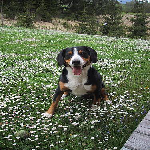

In [78]:
Image.open(PATH+fn).resize((150,150))

In [83]:
#Method  1

trn_tfms, val_tfms = tfms_from_model(arch,sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

42

In [84]:
learn.data.classes[np.argmax(preds)]

'entlebucher'

In [85]:
#Method 2
trn_tfms, val_tfms = tfms_from_model(arch,sz)
im = val_tfms(open_image(PATH+fn))
preds = learn.predict_array(im[None])
np.argmax(preds)

42

In [87]:
learn.data.classes[42]

'entlebucher'

In [88]:
{PATH}

{'/fastai/data/dogbreed/'}

In [89]:
PATH

'/fastai/data/dogbreed/'

In [153]:
listF = os.listdir(PATH+'mani-test')
listF

['IMG_0844.jpg',
 'IMG_0847.jpg',
 'Kenny-1.jpg',
 'Kenny-2.jpg',
 'Kenny-3.jpg',
 'Kenny-4.jpg',
 'bulldog.jpeg',
 'chihauha.jpeg',
 'cocker-spaniel.jpeg',
 'gm-sheperd.jpeg',
 'great-dane.jpeg',
 'pomeranian.jpeg',
 '330px-Female_German_Shepherd.jpg',
 'poodle.jpeg',
 'beagle.jpeg']

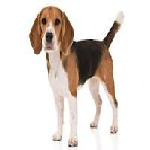

'beagle'

In [154]:
trn_tfms, val_tfms = tfms_from_model(arch,sz)
im = val_tfms(open_image(PATH+'mani-test/'+ listF[14]))
preds = learn.predict_array(im[None])
display(Image.open(PATH+'mani-test/'+ listF[14]).resize((150,150)))
display(learn.data.classes[np.argmax(preds)])
